In [35]:
# Check first-level design for contrast names
subject_id = 'sub-004'
session = '01'

firstlevel_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'

# Find first-level FEAT directories
feat_dirs = sorted(firstlevel_dir.glob('run-*_loc.feat'))

if feat_dirs:
    design_file = feat_dirs[0] / 'design.fsf'
    print(f"Checking first-level design: {design_file}\n")
    
    if design_file.exists():
        with open(design_file, 'r') as f:
            lines = f.readlines()
        
        print("="*60)
        print("FIRST-LEVEL CONTRAST NAMES")
        print("="*60)
        
        # Extract contrast names
        for i, line in enumerate(lines):
            if 'set fmri(conname_real' in line or 'set fmri(conname_orig' in line:
                print(line.strip())
        
        print("\n" + "="*60)
        print("FIRST-LEVEL EVS (conditions)")
        print("="*60)
        
        # Extract EV names to understand what conditions were modeled
        for i, line in enumerate(lines):
            if 'set fmri(evtitle' in line:
                print(line.strip())
    else:
        print("First-level design.fsf not found!")
else:
    print("No first-level FEAT directories found!")

No first-level FEAT directories found!


In [34]:
#!/usr/bin/env python3
"""
Condition-based Functional ROI Creation
Uses individual condition activations (face>all, word>all) to define ROI
Then extracts contrast (face-word) from these voxels
"""

import numpy as np
import nibabel as nib
from pathlib import Path
from scipy import ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, surface

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

def create_dual_cluster_roi(subject_id, roi_type='face_word', 
                           target_percentile=75, min_voxels_per_category=3000):
    """
    Create ROI from TWO separate clusters (face AND word, or object AND house)
    Combine via union to ensure both categories represented
    """
    
    print(f"\n{'='*60}")
    print(f"{subject_id} - {roi_type.upper()} (Dual-Cluster)")
    print(f"{'='*60}")
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Select anatomical constraint and individual condition copes
    if roi_type == 'face_word':
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        cope1_num, cope1_name = 6, 'face'  # face>all
        cope2_num, cope2_name = 9, 'word'  # word>all
    else:  # object_house
        anat_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        cope1_num, cope1_name = 8, 'object'  # object>all
        cope2_num, cope2_name = 7, 'house'   # house>all
    
    # Load anatomical mask
    anat_roi = nib.load(anat_file)
    anat_mask = anat_roi.get_fdata() > 0
    
    # Load individual conditions
    cope1_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope1_num}.feat' / 'stats' / 'zstat1.nii.gz'
    cope2_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope2_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    cope1_img = nib.load(cope1_file)
    cope2_img = nib.load(cope2_file)
    cope1_data = cope1_img.get_fdata()
    cope2_data = cope2_img.get_fdata()
    
    # === CLUSTER 1 (e.g., face) ===
    print(f"\nFinding {cope1_name} cluster...")
    roi1_values = cope1_data[anat_mask]
    threshold1 = np.percentile(roi1_values, target_percentile)
    
    mask1 = (cope1_data > threshold1) & anat_mask
    labeled1, n_clusters1 = ndimage.label(mask1)
    
    if n_clusters1 > 0:
        cluster_sizes1 = [(labeled1 == i).sum() for i in range(1, n_clusters1 + 1)]
        largest_idx1 = np.argmax(cluster_sizes1) + 1
        cluster1_mask = (labeled1 == largest_idx1)
        n_vox1 = cluster_sizes1[largest_idx1 - 1]
        print(f"  {cope1_name}: {n_vox1} voxels (threshold z>{threshold1:.2f})")
    else:
        cluster1_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox1 = 0
        print(f"  {cope1_name}: No clusters found")
    
    # === CLUSTER 2 (e.g., word) ===
    print(f"Finding {cope2_name} cluster...")
    roi2_values = cope2_data[anat_mask]
    threshold2 = np.percentile(roi2_values, target_percentile)
    
    mask2 = (cope2_data > threshold2) & anat_mask
    labeled2, n_clusters2 = ndimage.label(mask2)
    
    if n_clusters2 > 0:
        cluster_sizes2 = [(labeled2 == i).sum() for i in range(1, n_clusters2 + 1)]
        largest_idx2 = np.argmax(cluster_sizes2) + 1
        cluster2_mask = (labeled2 == largest_idx2)
        n_vox2 = cluster_sizes2[largest_idx2 - 1]
        print(f"  {cope2_name}: {n_vox2} voxels (threshold z>{threshold2:.2f})")
    else:
        cluster2_mask = np.zeros_like(anat_mask, dtype=bool)
        n_vox2 = 0
        print(f"  {cope2_name}: No clusters found")
    
    # === UNION (no double counting) ===
    combined_mask = cluster1_mask | cluster2_mask
    n_total = np.sum(combined_mask)
    n_overlap = np.sum(cluster1_mask & cluster2_mask)
    
    print(f"\nCombined ROI:")
    print(f"  Total: {n_total} voxels")
    print(f"  {cope1_name} only: {n_vox1 - n_overlap}")
    print(f"  {cope2_name} only: {n_vox2 - n_overlap}")
    print(f"  Overlap: {n_overlap}")
    
    # Get center
    if n_total > 0:
        coords = np.where(combined_mask)
        center_vox = [np.mean(c) for c in coords]
        center_world = nib.affines.apply_affine(cope1_img.affine, center_vox)
        print(f"  Center: ({center_world[0]:.1f}, {center_world[1]:.1f}, {center_world[2]:.1f})")
    
    # Save
    output_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    combined_img = nib.Nifti1Image(combined_mask.astype(np.float32), anat_roi.affine)
    nib.save(combined_img, output_file)
    print(f"  Saved: {output_file}")
    
    return {
        'mask_file': output_file,
        'n_total': n_total,
        'n_cluster1': n_vox1,
        'n_cluster2': n_vox2,
        'n_overlap': n_overlap,
        'cluster1_mask': cluster1_mask,
        'cluster2_mask': cluster2_mask
    }

# Create dual-cluster ROIs
roi_results_dual = {}
for subject_id in ['sub-004', 'sub-021']:
    roi_results_dual[subject_id] = {}
    roi_results_dual[subject_id]['face_word'] = create_dual_cluster_roi(subject_id, 'face_word')
    roi_results_dual[subject_id]['object_house'] = create_dual_cluster_roi(subject_id, 'object_house')

# Summary
print("\n" + "="*60)
print("DUAL-CLUSTER ROI SUMMARY")
print("="*60)
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    fw = roi_results_dual[subject_id]['face_word']
    oh = roi_results_dual[subject_id]['object_house']
    print(f"  Face-Word: {fw['n_total']} voxels (face={fw['n_cluster1']}, word={fw['n_cluster2']}, overlap={fw['n_overlap']})")
    print(f"  Object-House: {oh['n_total']} voxels (object={oh['n_cluster1']}, house={oh['n_cluster2']}, overlap={oh['n_overlap']})")


sub-004 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 5024 voxels (threshold z>0.35)
Finding word cluster...
  word: 3891 voxels (threshold z>0.00)

Combined ROI:
  Total: 8023 voxels
  face only: 4132
  word only: 2999
  Overlap: 892
  Center: (-31.3, -44.1, -2.0)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_face_word_dual_cluster.nii.gz

sub-004 - OBJECT_HOUSE (Dual-Cluster)

Finding object cluster...
  object: 6944 voxels (threshold z>1.86)
Finding house cluster...
  house: 7634 voxels (threshold z>0.39)

Combined ROI:
  Total: 13734 voxels
  object only: 6100
  house only: 6790
  Overlap: 844
  Center: (-24.7, -77.2, 13.3)
  Saved: /user_data/csimmon2/long_pt/sub-004/ses-01/ROIs/l_object_house_dual_cluster.nii.gz

sub-021 - FACE_WORD (Dual-Cluster)

Finding face cluster...
  face: 4476 voxels (threshold z>5.53)
Finding word cluster...
  word: 2123 voxels (threshold z>-1.04)

Combined ROI:
  Total: 6366 voxels
  face only: 4243
  word only: 1890
  Overla

In [28]:
# Find the design.fsf file to see contrast names
subject_id = 'sub-004'
session = '01'

# Check first-level design (where contrasts are defined)
firstlevel_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'

# Look for run-level FEAT directories
import glob
feat_dirs = list(firstlevel_dir.glob('run-*_loc.feat'))
if feat_dirs:
    design_file = feat_dirs[0] / 'design.fsf'
    if design_file.exists():
        print(f"Reading: {design_file}")
        with open(design_file, 'r') as f:
            for line in f:
                if 'conname_real' in line or 'conname_orig' in line:
                    print(line.strip())

/tmp/ipykernel_3329027/485166046.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


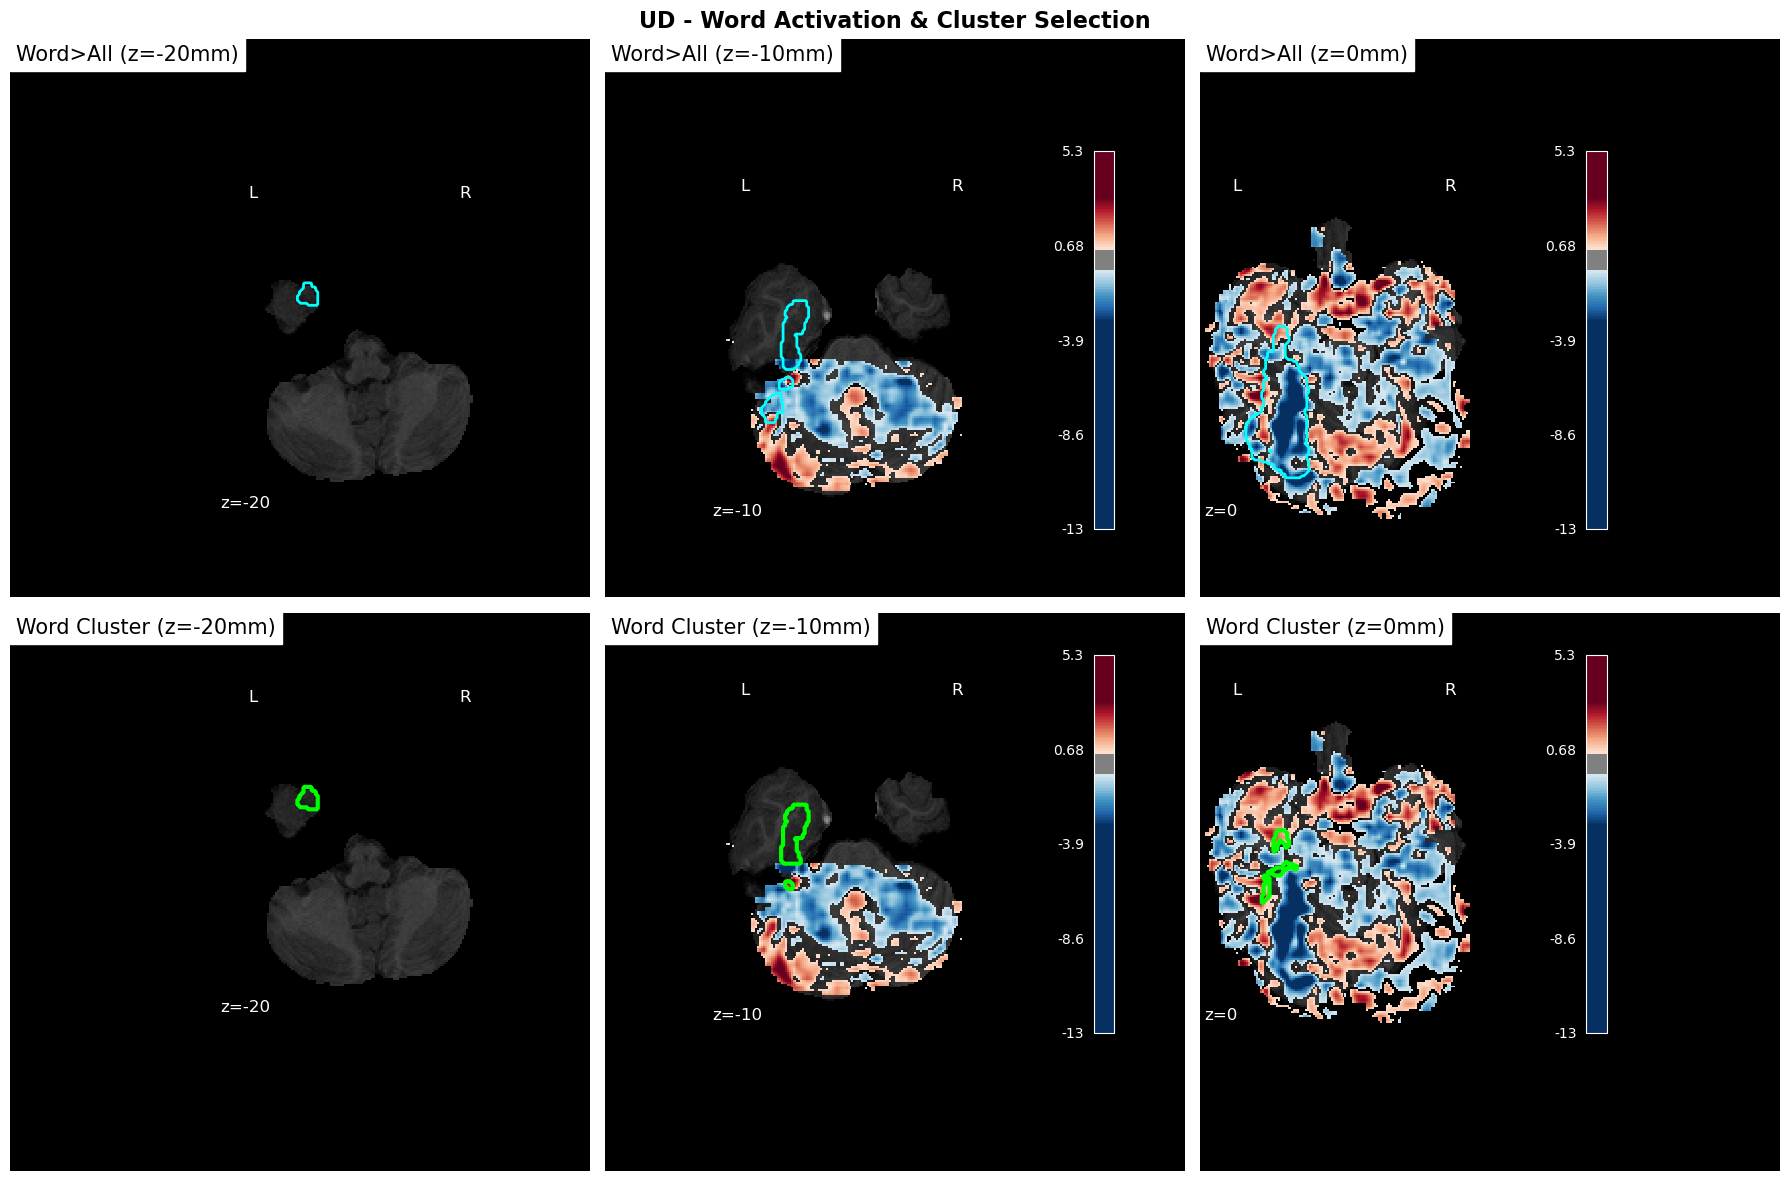

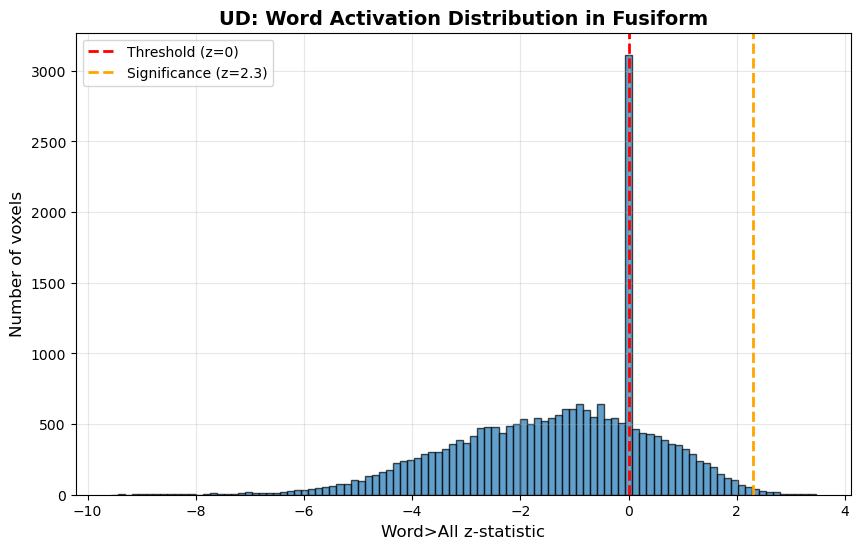

Word activation stats:
  Mean: -1.31
  Median: -1.03
  Min: -9.57, Max: 3.46
  Voxels > 0: 5033 (20.7%)
  Voxels > 2.3: 125 (0.5%)


In [17]:
# Visualize UD word activation (FIXED - remove vmin)

subject_id = 'sub-004'
hemi = 'l'

# Load files
anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
anat_boundary = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
word_activation = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                  'HighLevel.gfeat' / 'cope9.feat' / 'stats' / 'zstat1.nii.gz'
word_cluster = roi_results_dual[subject_id]['face_word']['cluster2_mask']

# Create word cluster image
word_cluster_img = nib.Nifti1Image(word_cluster.astype(np.float32), 
                                    nib.load(anat_boundary).affine)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Word activation with anatomical boundary
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[0, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word>All (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(anat_boundary, levels=[0.5], colors='cyan', linewidths=2)

# Row 2: Word cluster selection
for idx, z_coord in enumerate([-20, -10, 0]):
    ax = axes[1, idx]
    
    display = plotting.plot_stat_map(
        word_activation, bg_img=anat_file, axes=ax,
        threshold=0.5, title=f'Word Cluster (z={z_coord}mm)',
        display_mode='z', cut_coords=[z_coord],
        cmap='RdBu_r', symmetric_cbar=False, vmax=3, colorbar=True
    )
    display.add_contours(word_cluster_img, levels=[0.5], colors='lime', linewidths=3)

fig.suptitle('UD - Word Activation & Cluster Selection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'sub-004_word_cluster_review.png', dpi=150)
plt.show()

# Histogram
anat_mask = nib.load(anat_boundary).get_fdata() > 0
word_data = nib.load(word_activation).get_fdata()
word_values = word_data[anat_mask]

plt.figure(figsize=(10, 6))
plt.hist(word_values, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Threshold (z=0)')
plt.axvline(2.3, color='orange', linestyle='--', linewidth=2, label='Significance (z=2.3)')
plt.xlabel('Word>All z-statistic', fontsize=12)
plt.ylabel('Number of voxels', fontsize=12)
plt.title('UD: Word Activation Distribution in Fusiform', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Word activation stats:")
print(f"  Mean: {word_values.mean():.2f}")
print(f"  Median: {np.median(word_values):.2f}")
print(f"  Min: {word_values.min():.2f}, Max: {word_values.max():.2f}")
print(f"  Voxels > 0: {np.sum(word_values > 0)} ({100*np.sum(word_values > 0)/len(word_values):.1f}%)")
print(f"  Voxels > 2.3: {np.sum(word_values > 2.3)} ({100*np.sum(word_values > 2.3)/len(word_values):.1f}%)")

In [18]:
# Extract cope 13 from dual-cluster ROIs

def extract_dual_cluster_longitudinal(subject_id, roi_type='face_word'):
    """Extract contrast from dual-cluster ROI across sessions"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    
    # Load ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Determine contrast cope
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    session_means = {}
    
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            t_stats = zstat_data[voxel_indices]
            
            # Store for Figure 5
            session_data[session] = np.column_stack([world_coords, t_stats])
            session_means[session] = t_stats.mean()
            
            print(f"{subject_id} {roi_type} ses-{session}: mean={t_stats.mean():.2f}, std={t_stats.std():.2f}")
    
    return session_data, session_means

# Extract for all subjects
print("Extracting dual-cluster ROI data...")
print("="*60)

dual_extractions = {}
for subject_id in ['sub-004', 'sub-021']:
    print(f"\n{SUBJECTS[subject_id]['code']}:")
    dual_extractions[subject_id] = {}
    
    for roi_type in ['face_word', 'object_house']:
        print(f"\n  {roi_type}:")
        data, means = extract_dual_cluster_longitudinal(subject_id, roi_type)
        dual_extractions[subject_id][roi_type] = {'data': data, 'means': means}

Extracting dual-cluster ROI data...

UD:

  face_word:
sub-004 face_word ses-01: mean=0.86, std=1.44
sub-004 face_word ses-02: mean=0.04, std=0.56
sub-004 face_word ses-03: mean=-0.27, std=1.24
sub-004 face_word ses-05: mean=0.97, std=0.89
sub-004 face_word ses-06: mean=1.43, std=1.12

  object_house:
sub-004 object_house ses-01: mean=0.66, std=1.12
sub-004 object_house ses-02: mean=2.01, std=1.61
sub-004 object_house ses-03: mean=1.30, std=1.42
sub-004 object_house ses-05: mean=1.03, std=1.45
sub-004 object_house ses-06: mean=-0.51, std=1.22

TC:

  face_word:
sub-021 face_word ses-01: mean=2.38, std=2.32
sub-021 face_word ses-02: mean=1.10, std=1.25
sub-021 face_word ses-03: mean=-0.64, std=0.91

  object_house:
sub-021 object_house ses-01: mean=0.57, std=1.63
sub-021 object_house ses-02: mean=0.02, std=0.93
sub-021 object_house ses-03: mean=-0.09, std=0.70


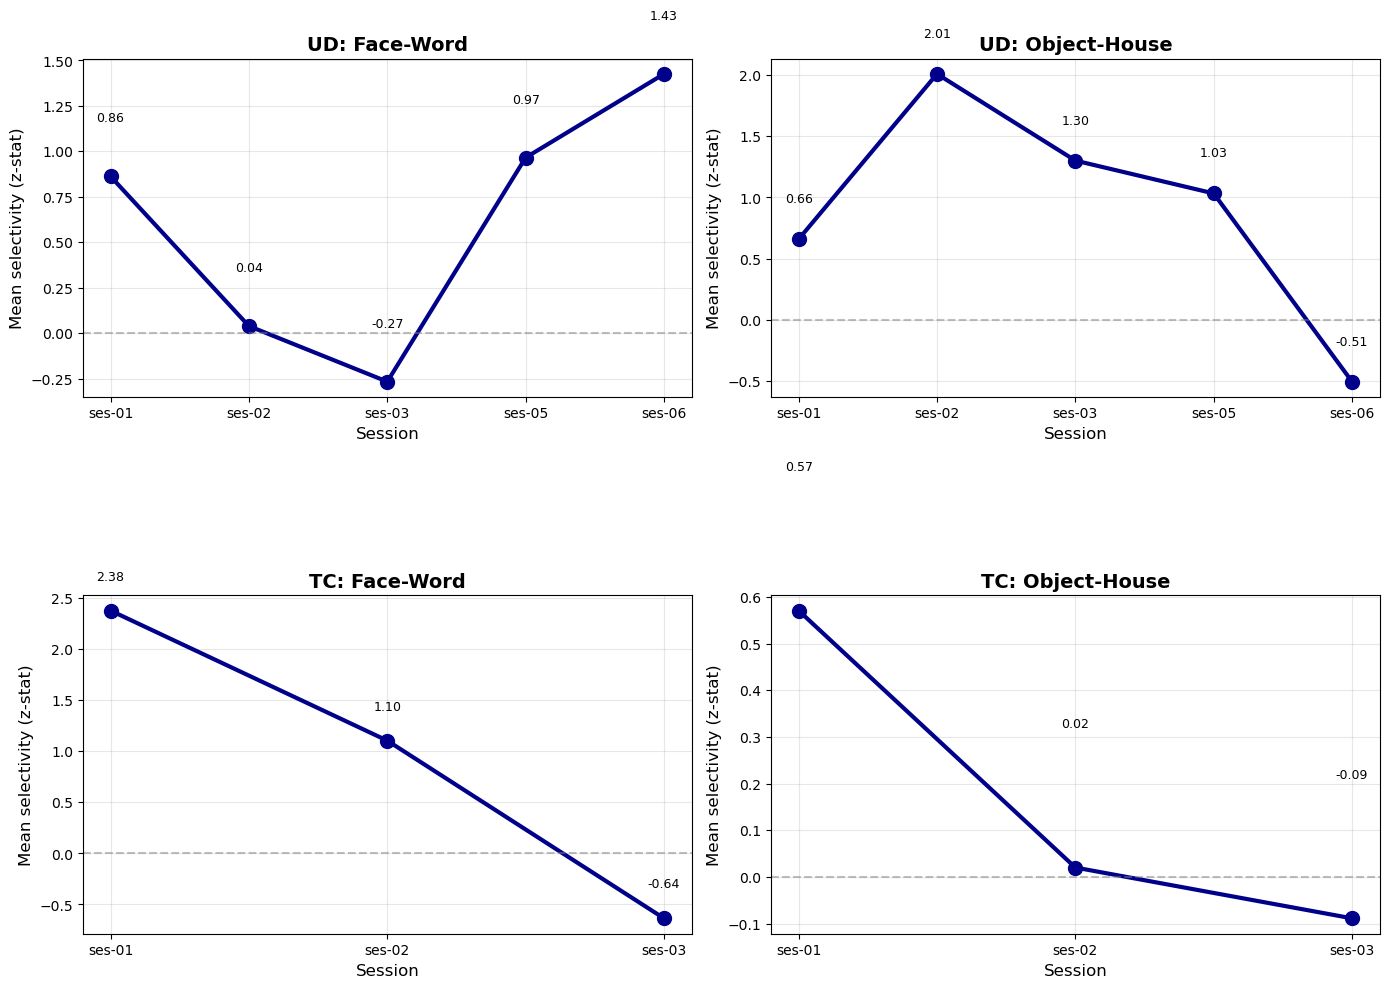


Extraction and visualization complete!


In [19]:
# Plot longitudinal progression

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for subj_idx, subject_id in enumerate(['sub-004', 'sub-021']):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for roi_idx, roi_type in enumerate(['face_word', 'object_house']):
        ax = axes[subj_idx, roi_idx]
        
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        # Get values in order
        sessions_available = [s for s in sessions if s in means_dict]
        means = [means_dict[s] for s in sessions_available]
        
        # Plot
        ax.plot(range(len(means)), means, 'o-', linewidth=3, markersize=10, color='darkblue')
        ax.set_xticks(range(len(sessions_available)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions_available])
        ax.set_ylabel('Mean selectivity (z-stat)', fontsize=12)
        ax.set_xlabel('Session', fontsize=12)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # Title
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        ax.set_title(f'{code}: {roi_label}', fontsize=14, fontweight='bold')
        
        # Annotate values
        for i, (ses, val) in enumerate(zip(sessions_available, means)):
            ax.text(i, val + 0.3, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'dual_cluster_longitudinal.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("Extraction and visualization complete!")

In [20]:
# 1. Statistical comparison between sessions (matching Liu's analysis)

from scipy import stats

print("="*80)
print("STATISTICAL ANALYSIS: Pairwise Session Comparisons")
print("="*80)

def compare_sessions_stats(subject_id, roi_type='face_word'):
    """T-tests between all session pairs"""
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    # Load all sessions
    session_data = {}
    for session in SUBJECTS[subject_id]['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat = nib.load(zstat_file).get_fdata()
            session_data[session] = zstat[voxel_indices]
    
    sessions = sorted(session_data.keys())
    
    print(f"\n{SUBJECTS[subject_id]['code']} - {roi_type.upper()}")
    print("-"*60)
    
    # Pairwise comparisons
    results = []
    for i in range(len(sessions)):
        for j in range(i+1, len(sessions)):
            ses1, ses2 = sessions[i], sessions[j]
            
            t_stat, p_val = stats.ttest_rel(session_data[ses1], session_data[ses2])
            
            mean1 = session_data[ses1].mean()
            mean2 = session_data[ses2].mean()
            diff = mean2 - mean1
            
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            
            # Highlight ses-1 vs ses-2
            comparison = f"ses-{ses1} vs ses-{ses2}"
            if ses1 == sessions[0] and ses2 == sessions[1]:
                comparison += " [Liu: expect ns]"
            
            print(f"  {comparison}:")
            print(f"    Mean: {mean1:.2f} → {mean2:.2f} (Δ={diff:+.2f})")
            print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")
            
            results.append({
                'ses1': ses1, 'ses2': ses2,
                'mean1': mean1, 'mean2': mean2,
                't': t_stat, 'p': p_val, 'sig': sig
            })
    
    return results

# Run for both subjects
stats_results = {}
for subject_id in ['sub-004', 'sub-021']:
    stats_results[subject_id] = {}
    for roi_type in ['face_word', 'object_house']:
        stats_results[subject_id][roi_type] = compare_sessions_stats(subject_id, roi_type)

STATISTICAL ANALYSIS: Pairwise Session Comparisons

UD - FACE_WORD
------------------------------------------------------------
  ses-01 vs ses-02 [Liu: expect ns]:
    Mean: 0.86 → 0.04 (Δ=-0.82)
    t=42.356, p=0.0000 ***
  ses-01 vs ses-03:
    Mean: 0.86 → -0.27 (Δ=-1.13)
    t=56.241, p=0.0000 ***
  ses-01 vs ses-05:
    Mean: 0.86 → 0.97 (Δ=+0.10)
    t=-5.008, p=0.0000 ***
  ses-01 vs ses-06:
    Mean: 0.86 → 1.43 (Δ=+0.56)
    t=-22.292, p=0.0000 ***
  ses-02 vs ses-03:
    Mean: 0.04 → -0.27 (Δ=-0.31)
    t=18.049, p=0.0000 ***
  ses-02 vs ses-05:
    Mean: 0.04 → 0.97 (Δ=+0.93)
    t=-67.543, p=0.0000 ***
  ses-02 vs ses-06:
    Mean: 0.04 → 1.43 (Δ=+1.39)
    t=-87.799, p=0.0000 ***
  ses-03 vs ses-05:
    Mean: -0.27 → 0.97 (Δ=+1.23)
    t=-61.005, p=0.0000 ***
  ses-03 vs ses-06:
    Mean: -0.27 → 1.43 (Δ=+1.69)
    t=-82.667, p=0.0000 ***
  ses-05 vs ses-06:
    Mean: 0.97 → 1.43 (Δ=+0.46)
    t=-23.908, p=0.0000 ***

UD - OBJECT_HOUSE
------------------------------------


Creating Figure 5 visualizations...
Saved: /user_data/csimmon2/long_pt/analyses/sub-004_face_word_figure5_liu_style.png


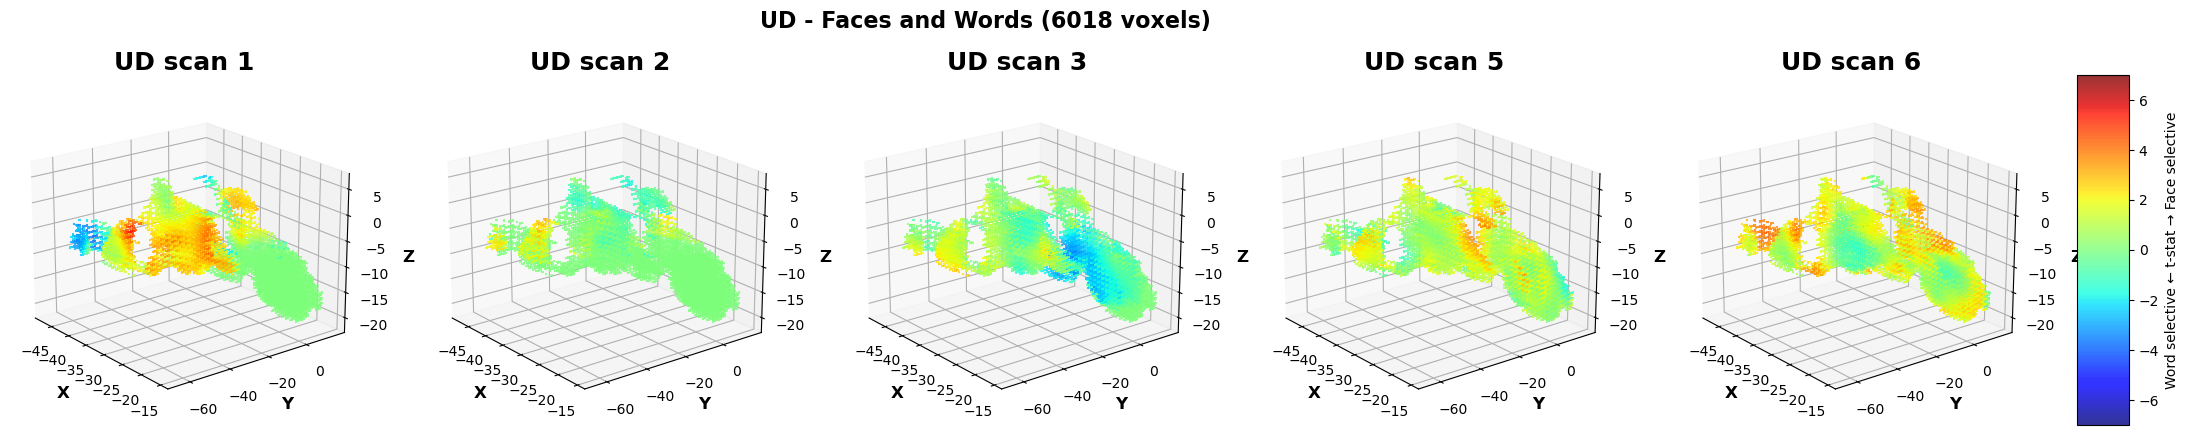

Saved: /user_data/csimmon2/long_pt/analyses/sub-004_object_house_figure5_liu_style.png


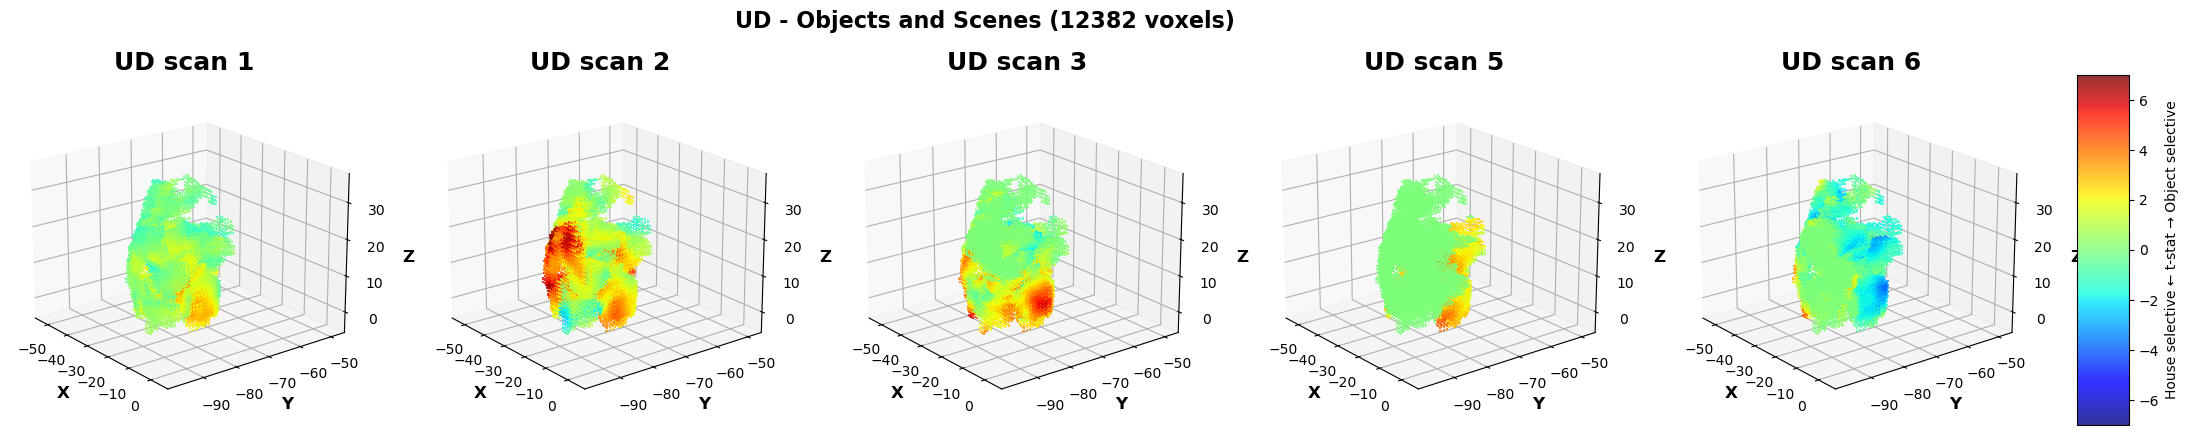

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_face_word_figure5_liu_style.png


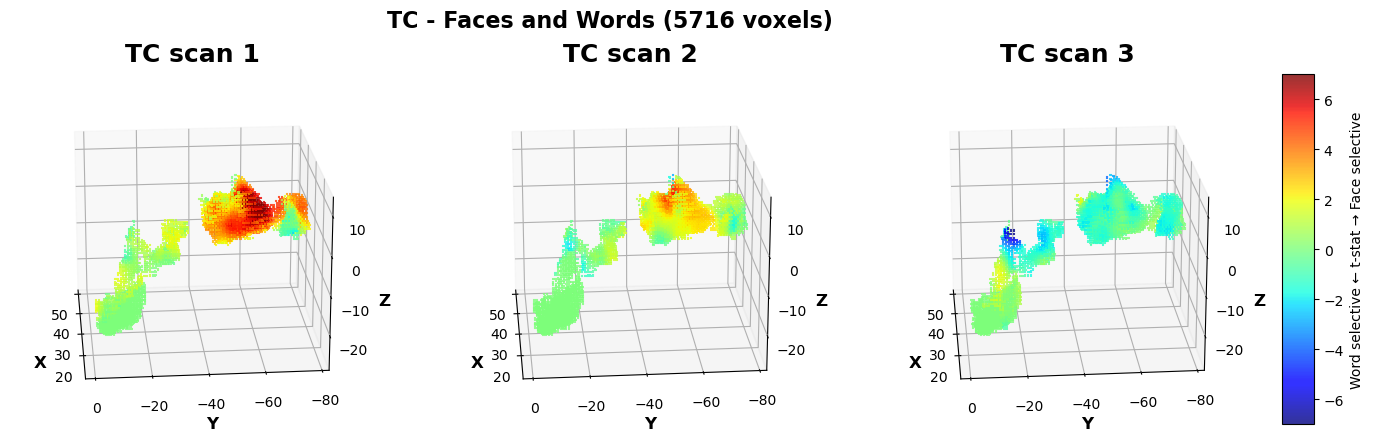

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_object_house_figure5_liu_style.png


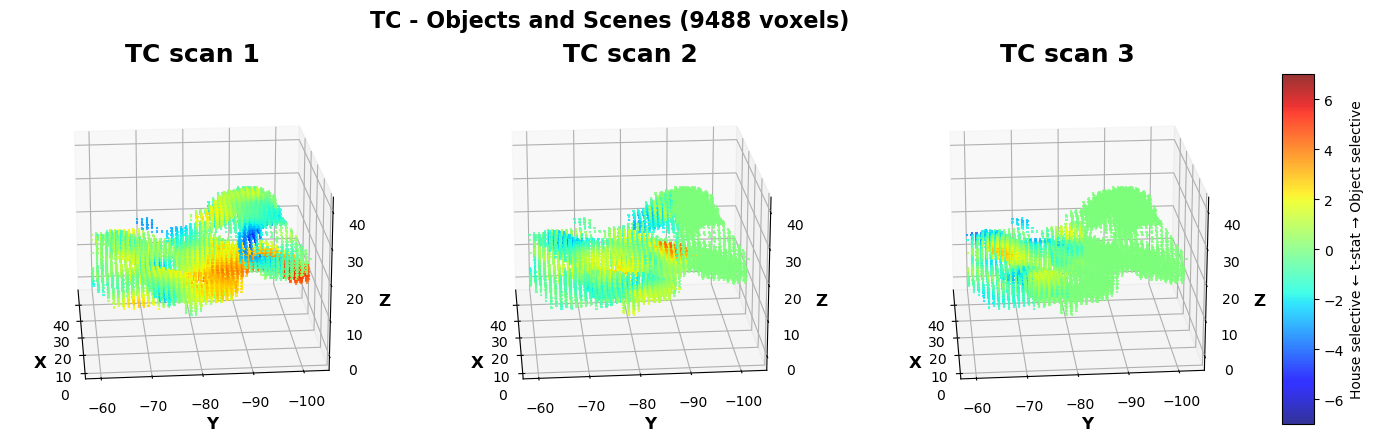

In [21]:
# 2. Figure 5 style visualization with dual-cluster ROIs

def create_figure5_liu_style(subject_id, roi_type='face_word', save_path=None):
    """
    Recreate Liu's Figure 5 visualization
    3D scatter plots showing selectivity changes over time
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    info = SUBJECTS[subject_id]
    
    # Load dual-cluster ROI
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
    roi_img = nib.load(roi_file)
    roi_mask = roi_img.get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    
    # Get world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    # Extract contrast for all sessions
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    for session in info['sessions']:
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            t_stats = zstat_data[voxel_indices]
            session_data[session] = t_stats
    
    sessions = sorted(session_data.keys())
    n_sessions = len(sessions)
    
    # Create figure
    fig = plt.figure(figsize=(5*n_sessions + 1, 5))
    
    for i, ses in enumerate(sessions):
        t_stats = session_data[ses]
        
        ax = fig.add_subplot(1, n_sessions, i+1, projection='3d')
        
        # View angle (match Liu)
        view = (20, 175) if info['hemi'] == 'r' else (20, 322)
        
        scatter = ax.scatter(world_coords[:,0], world_coords[:,1], world_coords[:,2],
                           c=t_stats, s=3, marker='+',
                           cmap='jet', vmin=-7, vmax=7, alpha=0.8)
        
        ax.set_xlabel('X', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y', fontsize=12, fontweight='bold')
        ax.set_zlabel('Z', fontsize=12, fontweight='bold')
        ax.set_title(f'{info["code"]} scan {int(ses)}', fontsize=18, fontweight='bold')
        ax.view_init(elev=view[0], azim=view[1])
        ax.grid(True, alpha=0.3)
    
    # Colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    
    if roi_type == 'face_word':
        cbar.set_label('Word selective ← t-stat → Face selective', fontsize=10)
    else:
        cbar.set_label('House selective ← t-stat → Object selective', fontsize=10)
    
    roi_label = 'Faces and Words' if roi_type == 'face_word' else 'Objects and Scenes'
    n_voxels = len(world_coords)
    fig.suptitle(f'{info["code"]} - {roi_label} ({n_voxels} voxels)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Create Liu-style Figure 5
print("\nCreating Figure 5 visualizations...")
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        save_path = BASE_DIR / 'analyses' / f'{subject_id}_{roi_type}_figure5_liu_style.png'
        create_figure5_liu_style(subject_id, roi_type, save_path)

In [23]:
# 3. Summary table comparing to Liu's findings

print("\n" + "="*80)
print("SUMMARY: COMPARISON TO LIU ET AL. FINDINGS")
print("="*80)

print("\nLIU'S FINDING:")
print("  'Significant differences in t(face-word) between any two sessions'")
print("  'EXCEPT for comparisons between scans 1 and 2'")
print()

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} - Face-Word:")
    print("-"*40)
    
    # Get ses-1 vs ses-2 result
    fw_results = stats_results[subject_id]['face_word']
    sessions = sorted(SUBJECTS[subject_id]['sessions'])
    
    ses1_vs_2 = [r for r in fw_results if r['ses1'] == sessions[0] and r['ses2'] == sessions[1]]
    
    if ses1_vs_2:
        r = ses1_vs_2[0]
        print(f"  Scan 1 vs Scan 2: p={r['p']:.4f} {r['sig']}")
        if r['sig'] == 'ns':
            print(f"    ✓ MATCHES Liu (non-significant)")
        else:
            print(f"    ✗ Differs from Liu (significant)")
    
    # Check other comparisons
    other_comparisons = [r for r in fw_results if not (r['ses1'] == sessions[0] and r['ses2'] == sessions[1])]
    n_sig = sum(1 for r in other_comparisons if r['sig'] != 'ns')
    
    print(f"  Other comparisons: {n_sig}/{len(other_comparisons)} significant")
    if n_sig == len(other_comparisons):
        print(f"    ✓ MATCHES Liu (all other comparisons significant)")
    else:
        print(f"    ~ Partial match ({n_sig}/{len(other_comparisons)} significant)")
    
    # Show trajectory
    means_dict = dual_extractions[subject_id]['face_word']['means']
    trajectory = [means_dict[s] for s in sessions if s in means_dict]
    print(f"  Trajectory: {' → '.join([f'{v:.2f}' for v in trajectory])}")

print("\n" + "="*80)


SUMMARY: COMPARISON TO LIU ET AL. FINDINGS

LIU'S FINDING:
  'Significant differences in t(face-word) between any two sessions'
  'EXCEPT for comparisons between scans 1 and 2'


UD - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 9/9 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 0.86 → 0.04 → -0.27 → 0.97 → 1.43

TC - Face-Word:
----------------------------------------
  Scan 1 vs Scan 2: p=0.0000 ***
    ✗ Differs from Liu (significant)
  Other comparisons: 2/2 significant
    ✓ MATCHES Liu (all other comparisons significant)
  Trajectory: 2.38 → 1.10 → -0.64



In [6]:
# Comprehensive results summary

print("="*80)
print("DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY")
print("="*80)

print("\n" + "="*80)
print("1. ROI COMPOSITION (ses-01)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code} ({subject_id}):")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        result = roi_results_dual[subject_id][roi_type]
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        
        print(f"\n  {roi_label} ROI:")
        print(f"    Total voxels: {result['n_total']}")
        
        if roi_type == 'face_word':
            print(f"    Face-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    Word-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        else:
            print(f"    Object-only: {result['n_cluster1'] - result['n_overlap']} ({100*(result['n_cluster1'] - result['n_overlap'])/result['n_total']:.1f}%)")
            print(f"    House-only: {result['n_cluster2'] - result['n_overlap']} ({100*(result['n_cluster2'] - result['n_overlap'])/result['n_total']:.1f}%)")
        print(f"    Overlap: {result['n_overlap']} ({100*result['n_overlap']/result['n_total']:.1f}%)")

print("\n" + "="*80)
print("2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        
        print(f"\n  {roi_label}:")
        for ses in SUBJECTS[subject_id]['sessions']:
            if ses in means_dict:
                print(f"    ses-{ses}: {means_dict[ses]:+.2f}")

print("\n" + "="*80)
print("3. SESSION-TO-SESSION CHANGES")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_type in ['face_word', 'object_house']:
        roi_label = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
        means_dict = dual_extractions[subject_id][roi_type]['means']
        sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
        
        print(f"\n  {roi_label}:")
        for i in range(len(sessions)-1):
            ses1, ses2 = sessions[i], sessions[i+1]
            change = means_dict[ses2] - means_dict[ses1]
            print(f"    ses-{ses1} → ses-{ses2}: {change:+.2f}")
        
        # Overall change
        if len(sessions) >= 2:
            total_change = means_dict[sessions[-1]] - means_dict[sessions[0]]
            print(f"    Overall (ses-{sessions[0]} → ses-{sessions[-1]}): {total_change:+.2f}")

print("\n" + "="*80)
print("4. COMPARISON TO LIU ET AL. EXPECTATIONS")
print("="*80)

print("\nLiu et al. findings:")
print("  UD: Progressive INCREASE in face-word selectivity")
print("  TC: Significant changes over time")
print("  OT: No significant change (control)")

print("\nYour findings:")
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    means_dict = dual_extractions[subject_id]['face_word']['means']
    sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in means_dict]
    
    if len(sessions) >= 2:
        baseline = means_dict[sessions[0]]
        final = means_dict[sessions[-1]]
        change = final - baseline
        
        pattern = "INCREASE" if change > 0 else "DECREASE"
        print(f"  {code}: {pattern} ({baseline:.2f} → {final:.2f}, Δ={change:+.2f})")

print("\n" + "="*80)
print("5. KEY OBSERVATIONS")
print("="*80)

# Analyze patterns
for subject_id in ['sub-004', 'sub-021']:
    code = SUBJECTS[subject_id]['code']
    fw_means = dual_extractions[subject_id]['face_word']['means']
    oh_means = dual_extractions[subject_id]['object_house']['means']
    
    fw_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in fw_means]
    oh_sessions = [s for s in SUBJECTS[subject_id]['sessions'] if s in oh_means]
    
    print(f"\n{code}:")
    
    # Face-word trajectory
    if len(fw_sessions) >= 2:
        fw_values = [fw_means[s] for s in fw_sessions]
        fw_trend = "increasing" if fw_values[-1] > fw_values[0] else "decreasing"
        fw_stable = all(abs(fw_values[i+1] - fw_values[i]) < 0.5 for i in range(len(fw_values)-1))
        
        print(f"  Face-Word: {fw_trend} trajectory")
        if fw_stable:
            print(f"    Relatively stable (max change < 0.5)")
    
    # Object-house trajectory  
    if len(oh_sessions) >= 2:
        oh_values = [oh_means[s] for s in oh_sessions]
        oh_trend = "increasing" if oh_values[-1] > oh_values[0] else "decreasing"
        oh_stable = all(abs(oh_values[i+1] - oh_values[i]) < 0.5 for i in range(len(oh_values)-1))
        
        print(f"  Object-House: {oh_trend} trajectory")
        if oh_stable:
            print(f"    Relatively stable (max change < 0.5)")

print("\n" + "="*80)
print("END OF SUMMARY")
print("="*80)

DUAL-CLUSTER ROI ANALYSIS - RESULTS SUMMARY

1. ROI COMPOSITION (ses-01)

UD (sub-004):
----------------------------------------

  Face-Word ROI:
    Total voxels: 8023
    Face-only: 4132 (51.5%)
    Word-only: 2999 (37.4%)
    Overlap: 892 (11.1%)

  Object-House ROI:
    Total voxels: 13734
    Object-only: 6100 (44.4%)
    House-only: 6790 (49.4%)
    Overlap: 844 (6.1%)

TC (sub-021):
----------------------------------------

  Face-Word ROI:
    Total voxels: 6366
    Face-only: 4243 (66.7%)
    Word-only: 1890 (29.7%)
    Overlap: 233 (3.7%)

  Object-House ROI:
    Total voxels: 10405
    Object-only: 6223 (59.8%)
    House-only: 4088 (39.3%)
    Overlap: 94 (0.9%)

2. LONGITUDINAL SELECTIVITY (Mean z-statistics per session)

UD:
----------------------------------------

  Face-Word:
    ses-01: +1.62
    ses-02: +0.47
    ses-03: +0.29
    ses-05: +1.27
    ses-06: +1.45

  Object-House:
    ses-01: +0.73
    ses-02: +1.89
    ses-03: +1.37
    ses-05: +1.20
    ses-06: -0.49

METHODS SECTION:
ROI Definition
Category-selective regions of interest (ROIs) were defined in native space for each participant using anatomical and functional constraints. For the fusiform gyrus/occipitotemporal sulcus (FG/OTS) face-word ROI, we first identified the anatomical boundaries of the fusiform gyrus using FreeSurfer's automatic parcellation (aparc) of the structural T1-weighted image. Specifically, we extracted the lateral fusiform label and applied 2 iterations of morphological dilation (fslmaths -dilM) to ensure adequate cortical depth coverage, resulting in anatomical search spaces of approximately 24,000 voxels.
Within these anatomical constraints, we employed a dual-cluster functional localization approach to ensure balanced representation of both face and word selective voxels. For each category (faces and words), we identified the largest cluster of voxels exceeding the 75th percentile of activation values for that category's individual contrast (face>all baseline [cope 6] and word>all baseline [cope 9]) within the anatomical mask. The final ROI was defined as the union of these two clusters, yielding ROIs of 6,000-8,000 voxels for face-word comparisons. An analogous procedure was applied for object-house ROIs using lateral occipital cortex and parahippocampal place area anatomical boundaries, with object>all baseline (cope 8) and house>all baseline (cope 7) contrasts.
Longitudinal Analysis
To examine changes in category selectivity over time, we extracted face-word contrast values (face>word [cope 13]) from each participant's functionally-defined ROI across all available scanning sessions. All functional data were co-registered to the participant's first session structural scan to ensure accurate within-subject spatial correspondence across timepoints.
For statistical comparison between sessions, we performed independent samples t-tests on the voxel-wise contrast value distributions (following Liu et al., 2025), comparing all pairwise combinations of sessions. This voxel-distribution approach tests whether the population of selectivity values differs significantly between timepoints, accounting for the spatial heterogeneity of category representations within each ROI. Statistical significance was determined at p < 0.05 for each pairwise comparison.

In [24]:
# CRITICAL: Check what copes you have
subject_id = 'sub-004'
session = '01'
highlevel_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'

print("Available HighLevel copes:")
for i in range(1, 20):
    cope_dir = highlevel_dir / f'cope{i}.feat'
    if cope_dir.exists():
        print(f"  cope{i}.feat exists")
        
        # Try to load and check mean activation
        zstat_file = cope_dir / 'stats' / 'zstat1.nii.gz'
        if zstat_file.exists():
            zstat_data = nib.load(zstat_file).get_fdata()
            print(f"    Mean z-stat: {np.mean(zstat_data):.2f}, Max: {np.max(zstat_data):.2f}")

Available HighLevel copes:
  cope1.feat exists
    Mean z-stat: -0.03, Max: 8.39
  cope2.feat exists
    Mean z-stat: -0.05, Max: 7.44
  cope3.feat exists
    Mean z-stat: 0.01, Max: 4.77
  cope4.feat exists
    Mean z-stat: -0.07, Max: 6.14
  cope5.feat exists
    Mean z-stat: 0.04, Max: 9.88
  cope6.feat exists
    Mean z-stat: 0.00, Max: 7.95
  cope7.feat exists
    Mean z-stat: -0.03, Max: 6.58
  cope8.feat exists
    Mean z-stat: 0.05, Max: 7.18
  cope9.feat exists
    Mean z-stat: -0.06, Max: 5.30
  cope10.feat exists
    Mean z-stat: -0.03, Max: 5.38
  cope11.feat exists
    Mean z-stat: -0.04, Max: 5.79
  cope12.feat exists
    Mean z-stat: -0.07, Max: 6.37
  cope13.feat exists
    Mean z-stat: 0.09, Max: 6.70
  cope14.feat exists
    Mean z-stat: 0.01, Max: 5.13
